In [7]:
"""
Created on Thu Apr 13 10:08:24 2017
@author: kevin
Adapted 2017-05-08 as inspired by:
http://stackoverflow.com/questions/6862770/python-3-let-json-object-accept-bytes-or-let-urlopen-output-strings
"""

from urllib import urlopen 
import json
import codecs
import pymongo
'''Get the records from fda'''
def getRecords(num_records = 100, start_date='20120101', end_date='20161231'):
    reader = codecs.getreader('utf-8')
    #num_records = 4587015
    records = []
    i = 0
    while i in range(0,num_records):#go through all records
        i+=100
        #i = i%5000#limit for skip, as per FDA api
        url = "https://api.fda.gov/drug/event.json?api_key=QIYs3xaRHyjYEkcprTinxbS6QXABp4cu55ZcR2iV&search=receivedate:[" + str(start_date) + "+TO+" + str(end_date) + "]&limit=100" + "&skip=" + str(i)
        response = urlopen(url)
        data = json.load(reader(response))
        print(i)
        results = data["results"]
        records.extend(results)
    '''
    #save data
    with open('drug_adverse_events.json', 'w') as outfile:
        json.dump(records, outfile)
        
    for record in records:
        print record["transmissiondate"]
    '''
    return records

In [8]:
'''sanity check'''
record = getRecords(num_records=100, start_date='20120101', end_date='20161231')

100


In [9]:
def get_recursively(search_dict, field):
    """Takes a dict with nested lists and dicts,
    and searches all dicts for a key of the field
    provided.
    """
    fields_found = []

    for key, value in search_dict.iteritems():

        if key == field:
            fields_found.append(value)

        elif isinstance(value, dict):
            results = get_recursively(value, field)
            for result in results:
                fields_found.append(result)

        elif isinstance(value, list):
            for item in value:
                if isinstance(item, dict):
                    more_results = get_recursively(item, field)
                    for another_result in more_results:
                        fields_found.append(another_result)
    #we want to return a list of values, and we do not want to try and iterate over some none type
    
    new_field_found = []
    if type(fields_found) == list:
        for sublist in fields_found:
            if type(sublist) == list:
                for val in sublist:
                    new_field_found.append(convert_to_float(val))#also convert to float
            else:
                new_field_found.append(convert_to_float(sublist))#also convert to float
    return list(set(new_field_found))

#This gives us the keys using the dot notation. It also gives us an empty 
#string if we dont find the key. It also checks if the next value is inside of a list.
#Some work needs to be done on this. I am not keeping the structure. We dont need
#the structure to stay the same
#TODO:
#    We need to make sure that we can go in through an arbitrary number of lists.
#    It works for an arbitrary number of dicts.
#'''

In [10]:
def getNessessaryKeyValues(record):
    fields = ['safetyreportid',
            'receivedate',
            'serious',
            'seriousnessdeath',
            'seriousnessdisabling',
            'seriousnesshospitalization',
            'seriousnesslifethreatening',
            'seriousnessother',
            'transmissiondate',
            'duplicate',
            'companynumb',
            'occurcountry',
            'primarysourcecountry',
            #'primarysource',
            'qualification',
            'reportercountry',
            #'reportduplicate',
            'duplicatesource',
            'duplicatenumb',
            "patientonsetage",
            "patientonsetageunit",
            "patientsex",
            #"patient.patientweight",#interseting, this data may be useful but is not recorded much
            "patientdeath",
            "patientdeathdate",
            "actiondrug",
            #"patient.drug.drugadditional",
            #"patient.drug.drugcumulativedosagenumb",
            #"patient.drug.drugcumulativedosageunit",
            "drugdosageform",
            #"patient.drug.drugintervaldosagedefinition",
            #"patient.drug.drugrecurreadministration",
            #"patient.drug.drugseparatedosagenumb",
            "drugadministrationroute",
            "drugcharacterization",
            "drugdosagetext",
            'drugenddate',#sometimes patients do not have an end date? maybe replace with some value like -1
            'drugindication',
            'drugstartdate',
            #'patient.drug.drugtreatmentduration',
            #'patient.drug.drugtreatmentdurationunit',
            'medicinalproduct',
            'brand_name',
            'generic_name',
            'manufacturer_name',
            'nui',
            'package_ndc',
            'pharm_class_cs',
            'pharm_class_epc',
            'pharm_class_pe',
            'pharm_class_moa',
            'product_ndc',
            'rxcui',
            'substance_name',
            'reactionmeddrapt',
            'reactionmeddraversionpt',
            'reactionoutcome'
            ]
    subrecord = {}
    for f in fields:
        extracted_record = get_recursively(record, f)
        #we get the key and try to convert to float, otherwise return the same val
        s_record = {}
        if not extracted_record:
            s_record[f] = None
        elif(len(extracted_record) < 2):#if the result is just 1 value, then return that value not a list
            s_record[f] = extracted_record[0]
        else:
            s_record[f] = extracted_record
        subrecord.update(s_record)
    return subrecord


In [11]:
def convert_to_float(s):
    try:
        return float(s)
    except ValueError:
        return s
    except TypeError:
        return s

In [12]:
import pandas as pd

subrecords = []#Get all the records and pull out the stuff we need
for recor in record:
    subrecords.append(getNessessaryKeyValues(recor))
#del records#save memory
#del record

x_y_dataframe = pd.DataFrame(subrecords)
#x_y_dataframe.dropna(how='any')#here we can drop a row if there is any na
#del subrecords

#x_y_dataframe2 = x_y_dataframe.dropna(axis=0)
#get labels
#(x,y) = get_y_vals(x_y_dataframe, 'serious')
#del x_y_dataframe


In [13]:
'''Retrieve data_cols (variables) that are complete - additional variables can be added to this list'''
#x_y_dataframe.columns
#only looked at complete records with columns in data_cols. New dataframe = df_notnan
#'patientdeath', 'seriousnessdeath', 'seriousnessdisabling','seriousnesshospitalization', 'seriousnesslifethreatening','seriousnessother'
data_cols = ['patientonsetage','safetyreportid','serious','occurcountry','patientsex','pharm_class_epc','reactionmeddrapt','reactionoutcome']
df_notnan = x_y_dataframe[data_cols].dropna()
df_notnan['patientsex'][df_notnan['patientsex'] == 1.0] = 'Male'
df_notnan['patientsex'][df_notnan['patientsex'] == 2.0] = 'Female'
#df_notnan


In [14]:
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tools import plotting
import requests
#import seaborn as sns
import numpy as np
from sklearn import preprocessing
%matplotlib inline  
import seaborn as sns

In [15]:
'''Boxplot function - df = dataframe'''
def show_boxplot(df,x,y,color):
    sns.set(style="ticks")
    sns.boxplot(x=x, y=y, hue=color, data=df, palette="PRGn")
    #sns.boxplot(x=x, y=y, hue=color, data=df_notnan, palette="PRGn")
    sns.despine(offset=10, trim=True)
    sns.plt.show()

In [16]:
'''Count reactions for each patient - created 2 new columns(dict/series)'''
df_notnan['reactionmed_count'] = df_notnan['reactionmeddrapt'].apply(lambda x: len(x) if isinstance(x,list) else 1)
df_notnan['reactionoutcomereal'] = df_notnan['reactionoutcome'].apply(lambda x: x[0] if isinstance(x,list) else x)
df_notnan['pharmclass_count'] = df_notnan['pharm_class_epc'].apply(lambda x: len(x) if isinstance(x,list) else 1)
#df_notnan

In [17]:
'''Extract Ontology URLs and insert them into dataframe for each patient id'''
def extract_SNOMEID(url):
    return url.split('/')[-1]

def pull_url(field):
    URL = 'https://data.bioontology.org/annotator'
    
    data = {
    'apikey': '1aa5877a-b18b-43a2-bf2d-15a2637638f8',
    'text': field,
    'longest_only': False,
    'whole_word_only': True,
    'exclude_numbers': False,
    'exclude_synonyms': False,
    'ontologies': 'SNOMEDCT'
    }
    annotated = json.loads(requests.post(URL, data=data).text)
    #print('\n')
    #print(field)
    #print(annotated[0])
    url = annotated[0]['annotatedClass']['@id']
    return url

df_notnan['ontology'] = np.nan
df_notnan['ontology'] = df_notnan['ontology'].astype('object')

for i,row in df_notnan.iterrows():
    data = row['reactionmeddrapt']
    #print(data)
    if isinstance(data,list):
        urls= []
        smeids = []
        for check in data:
            #print('LIST\n')
            url = pull_url(check)
            urls.append(url)
            smeid = extract_SNOMEID(url.encode('utf8'))
            smeids.append(smeid)

        df_notnan.set_value(i,'ontology',smeids)
        #df_notnan.set_value(i,'url',url)#can remove....this may not be needed(takes way too long to get)
    else:
        #print('NOT LIST\n')
        #print(data)
        url = pull_url(data)
        smeid = extract_SNOMEID(url.encode('utf8'))
        df_notnan.set_value(i,'ontology',smeid)
        #df_notnan.set_value(i,'url',url)#can remove...this may may not be needed (takes way too long to get)
            
            
#df_notnan         

In [18]:
'''iterate through rows regardless to retrieve all reactions (list or element) and associated age and gender
into new dataframe (df2)'''
age = []
sex = []
reactions = []

for i,row in df_notnan.iterrows():
    rr = row['reactionmeddrapt']
    s = row['patientsex']
    a = row['patientonsetage']
    #if row['reactionmed_count']>1:
    if isinstance(rr,list) and len(rr)>1 and len(rr[0])>1:
        reactions+=rr
        for j in range(len(rr)):
            sex.append(s)
            age.append(a)
    else:
        reactions.append(rr)
        sex.append(s)
        age.append(a)
#df2 = pd.DataFrame([age,sex,reactions],columns=['age','sex','reactions'])
df2 = pd.DataFrame({'age':age,'sex':sex,'reactions':reactions})
#[len(age), len(sex),len(reactions)]

    
    

In [21]:
'''Statistical Significance Test - TTest'''
groups = df_notnan.groupby('serious')
for groupname,groupval in groups:
    data1 = groupval['patientonsetage'][groupval['patientsex']=='Male']
    data2 = groupval['patientonsetage'][groupval['patientsex']=='Female']
    print(groupname)
    print(stats.ttest_ind(data1, data2))
    

1.0
Ttest_indResult(statistic=1.0723691492927119, pvalue=0.30875112142331146)
2.0
Ttest_indResult(statistic=-0.49357933837942836, pvalue=0.62310557821988688)


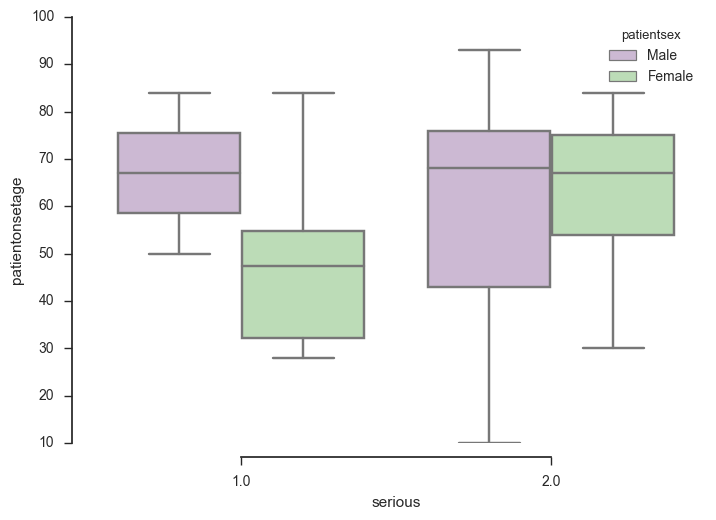

In [22]:
show_boxplot(df_notnan,"serious","patientonsetage","patientsex")

In [24]:
'''Top reactions'''
from collections import Counter
Counter(df2['reactions']).most_common(5)

[(u'Dyspnoea', 17),
 (u'Cough', 9),
 (u'Fatigue', 9),
 (u'Unevaluable event', 6),
 (u'Peripheral swelling', 4)]

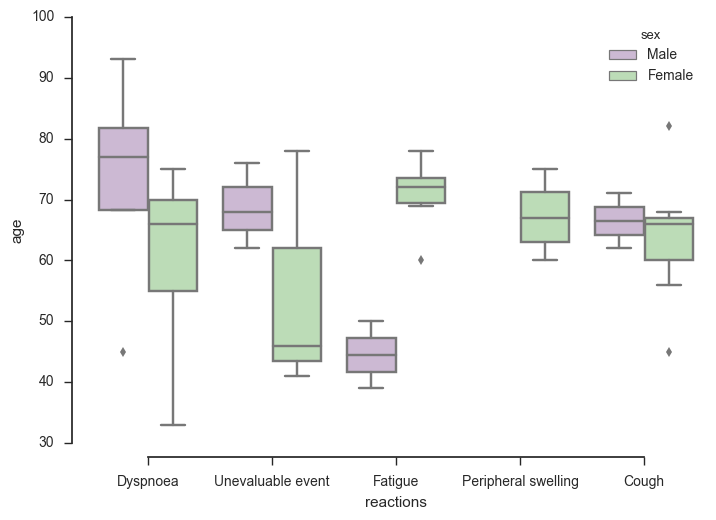

In [33]:
'''Age and Sex grouped by Reactions'''
top5 = [x for x,y in Counter(df2['reactions']).most_common(5)]; top5
show_boxplot(df2[df2['reactions'].isin(top5)],"reactions","age","sex")

{u'FR': 1, u'ES': 1, u'US': 80, u'CN': 4}


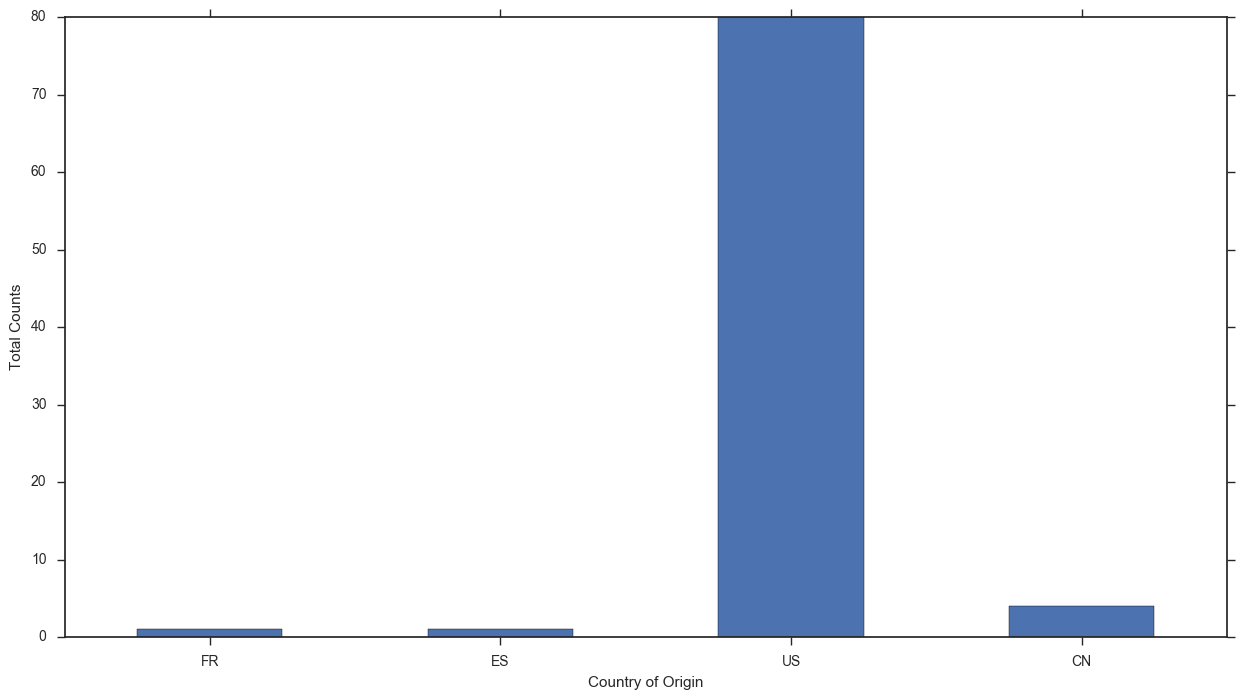

In [34]:
countrycounts = {}
fig,ax = plt.subplots(figsize=(15,8))
for row in df_notnan.itertuples():
    country = row.occurcountry
    countrycount = countrycounts.get(country, 0)
    countrycounts[country]=countrycount+1
print countrycounts
xlocations = np.array(range(len(countrycounts)))
width = 0.5
ax.bar(xlocations, countrycounts.values(), width=width, align = 'center')
plt.xticks(range(len(countrycounts)),countrycounts.keys())
plt.xlabel('Country of Origin')
plt.ylabel('Total Counts')

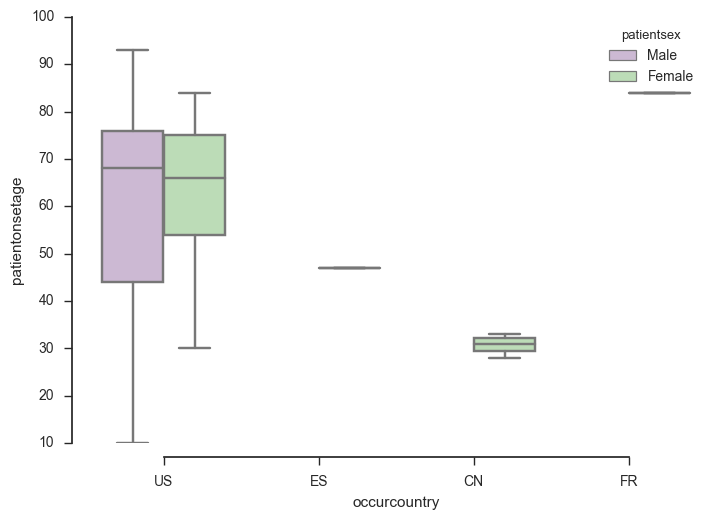

In [36]:
show_boxplot(df_notnan, "occurcountry","patientonsetage","patientsex")

<type 'numpy.float64'>
<type 'numpy.float64'>


''

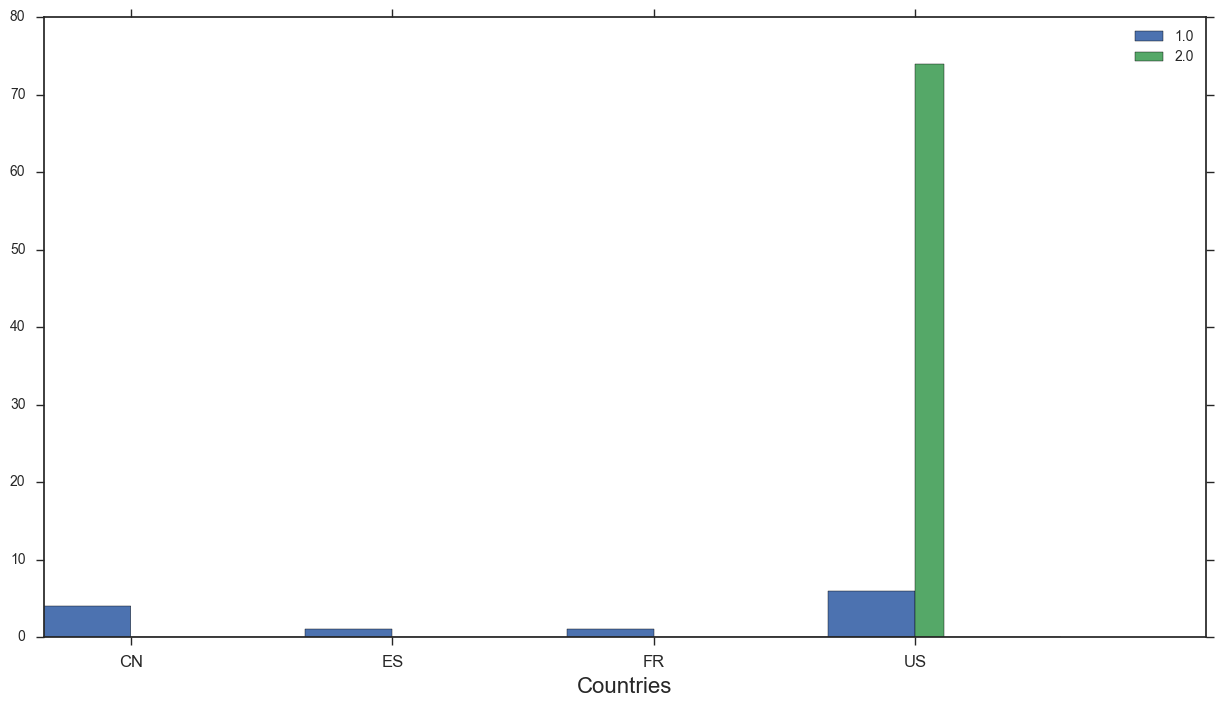

In [37]:
'''Group Histogram - Serious Vs Country'''

#x,y,z = np.unique(df_notnan['occurcountry'],return_inverse=True,return_counts=True) #https://docs.scipy.org/doc/numpy-1.10.4/reference/generated/numpy.unique.html
#df_notnan['occurcountry'].value_counts()
#df_notnan['occurcountry'][y==3]
'''transform non-numerical labels '''
le = preprocessing.LabelEncoder()
df_notnan['occurcountry_num'] = le.fit_transform(df_notnan['occurcountry'])
df_notnan['patientsex_num'] = le.fit_transform(df_notnan['patientsex'])

groups = df_notnan.groupby(['serious'])
fig,ax = plt.subplots(figsize=(15,8))
axs = []
for groupname,groupval in groups:
    #sns.distplot(groupval['occurcountry_num'], kde=False)
    print(type(groupname))
    a = ax.hist(groupval['occurcountry_num'],label=str(groupname))
    #a = ax.bar(groupval['occurcountry_num'].value_counts(),align='center')
    axs.append(a)
    #print(groupval['occurcountry_num'])
ax.set_xlabel('Countries',fontsize=16)
ax.set_xticks([0.3,1.2,2.1,3]) #Play with these to line up the ticks with the bars
ax.set_xticklabels(np.unique(df_notnan['occurcountry']),fontsize=12)
#ax.legend(axs,np.unique(df_notnan['serious']))
ax.legend()
''''''

In [6]:

def get_dotted(d, keys):
    if "." in keys:
        key, rest = keys.split(".", 1)
        if type(d) == list:#make sure its not a list
            d = d[0]
        if type(d[key]) != list and type(d[key]) != dict:#make sure its either a dict or list, otherwise return empty
            if keys not in d:
                d[keys] = None#some empty value
            return {rest: d[key]}
        return get_dotted(d[key], rest)
    else:
        if type(d) == list:#make sure its not a list
            d = d[0]
        if keys not in d:
            d[keys] = None#some empty value
        
        subDic = {keys: d[keys]}
        return subDic

In [21]:
def get_y_vals(df, y_label):
    #df.loc[pandas.isnull(df[y_label])] = ""#missing data
    #df.loc[df[y_label].str.contains("", na=False)] = 0
    y = df[y_label]
    del df[y_label]
    return (df, y)#return the new dataframe and y array

'''
Returns a trained naive_bays model
'''

'\nReturns a trained naive_bays model\n'

In [ ]:
def naive_bays(x_train, y_train, bagging = False, boosting = False):
    from sklearn.naive_bayes import GaussianNB as NB
    nb = NB()
    if bagging == True and boosting == True:
        raise ValueError("Cant have bagging and boosting enabled at the same time")
    if bagging == True:#if bagging
        from sklearn.ensemble import BaggingClassifier
        model = BaggingClassifier (nb, max_samples=.5, max_features=.5)
    elif boosting == True:
        from sklearn.ensemble import AdaBoostClassifier
        model = AdaBoostClassifier(nb,
                         algorithm="SAMME",
                         n_estimators=300)
    else:#just regular logistic regression
        model = nb
    model.fit(x_train, y_train)
    return model
'''
Returns a trained logistic regression model
'''

In [ ]:
def logistic_regression(x_train, y_train, bagging = False, boosting = False):
    from sklearn import linear_model
    lr = linear_model.LogisticRegression()
    if bagging == True and boosting == True:
        raise ValueError("Cant have bagging and boosting enabled at the same time")
    if bagging == True:#if bagging
        from sklearn.ensemble import BaggingClassifier
        model = BaggingClassifier (lr, max_samples=.5, max_features=.5)
    elif boosting == True:
        from sklearn.ensemble import AdaBoostClassifier
        model = AdaBoostClassifier(lr,
                         algorithm="SAMME",
                         n_estimators=300)
    else:#just regular logistic regression
        model = lr
    model.fit(x_train, y_train)
    return model

In [ ]:

def random_forest(x_train, y_train, estimators = 100, maxDepth = None, randomState = 10, maxFeatures = 'auto'):
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(n_estimators=estimators, max_depth=maxDepth,
                           random_state=randomState, max_features=maxFeatures)
    model.fit(x_train, y_train)
    return model

'''
split arrays into evenly sized chunks
'''

In [ ]:
def chunks(array, n):
    """Yield successive n-sized chunks from array."""
    for i in xrange(0, len(array), n):
        yield array[i:i + n]

In [ ]:
#Auto encodes any dataframe column of type category or object.
def dummyEncode(df):
    from sklearn.preprocessing import LabelEncoder
    columnsToEncode = list(df.select_dtypes(include=['category','object']))
    le = LabelEncoder()
    for feature in columnsToEncode:
        try:
            df[feature] = le.fit_transform(df[feature])
        except:
            print('Error encoding '+feature)
    return df

In [ ]:
def one_hot_encode(categorical_labels):
    res = []
    tmp = None
    for col in categorical_labels:
        v = x[col].astype(str).str.strip('[]').str.get_dummies(', ')#cant set a prefix
        if len(res) == 2:
            tmp = pandas.concat(res, axis=1)
            del res
            res = []
            res.append(tmp)
            del tmp
            tmp = None
        else:
            res.append(v)
    result = pandas.concat(res, axis=1)
    return result

In [ ]:
if __name__ == '__main__':
    #main method
    records = getRecords(num_records=1000)#get records
    
    #save to disk
    with open('data.json', 'w') as outfile:
        json.dump(records, outfile)
    #read from disk
    with open('data.json') as json_data:
        records = json.load(json_data)
    subrecords = []#Get all the records and pull out the stuff we need
    for record in records:
        subrecords.append(getNessessaryKeyValues(record))
    del records#save memory
    del record
    
    import pandas
    x_y_dataframe = pandas.DataFrame(subrecords)
    #x_y_dataframe.dropna(how='any')#here we can drop a row if there is any na
    del subrecords
    
    #x_y_dataframe2 = x_y_dataframe.dropna(axis=0)
    #get labels
    (x,y) = get_y_vals(x_y_dataframe, 'serious')
    del x_y_dataframe
    #df = pandas.DataFrame([{'drug': ['drugA','drugB'], 'patient': 'john'}, {'drug': ['drugC','drugD'], 'patient': 'angel'}])
    
    categorical_labels = [
 'actiondrug',
 'brand_name',
 'companynumb',
 'drugadministrationroute',
 'drugcharacterization',
 'drugdosageform',
 'drugdosagetext',
 'drugenddate',
 'drugindication',
 'drugstartdate',
 #'duplicate',
 'duplicatenumb',
 'duplicatesource',
 'generic_name',
 'manufacturer_name',
 'medicinalproduct',
 'nui',#has lists
 'occurcountry',
 'package_ndc',
 'patientdeath',
 'patientdeathdate',
 #'patientonsetage',
 'patientonsetageunit',
 'patientsex',
 'pharm_class_cs',
 'pharm_class_epc',
 'pharm_class_moa',
 'pharm_class_pe',
 'primarysourcecountry',
 'product_ndc',
 #'qualification',
 'reactionmeddrapt',
 'reactionmeddraversionpt',
 'reactionoutcome',
 #'receivedate',
 'reportercountry',
 'rxcui',
 #'safetyreportid',
 'seriousnessdeath',
 'seriousnessdisabling',
 'seriousnesshospitalization',
 'seriousnesslifethreatening',
 'seriousnessother',
 'substance_name',
 #'transmissiondate'
 ]
    #save data
    x.to_pickle('x_data.pkl')
    y.to_pickle('y_data.pkl')
    #load data
    import pandas
    x = pandas.read_pickle('x_data.pkl')
    y = pandas.read_pickle('y_data.pkl')
    
    '''
    get difference in labeles we are one-hot encoding and ones we aren't
    We need to preserve the ones we arent one-hot encoding
    '''
    s = set(categorical_labels)
    not_categorical_labels = [x_val for x_val in list(x) if x_val not in s]
    x_non_cat_labels = x[not_categorical_labels]#save non cat to temp var
    
    num_processors = 4
    n_size = int(round(len(categorical_labels)/num_processors))
    import time
    import multiprocessing
    
    start_time = time.time()
    p = multiprocessing.Pool(num_processors)
    res = (p.map(one_hot_encode, list(chunks(categorical_labels, n_size))))
    print (time.time()-start_time)
    p.terminate()#kill the workers
    res.append(x_non_cat_labels)
    del x_non_cat_labels
    x = pandas.concat(res, axis=1)
    y = pandas.to_numeric(y.astype(str).str.strip('[]'))
    x = x.dropna(how='any')
    y = y[x.index]
#    y[y.isnull()] = 0#we do this to convert nans, if its empty, we set it to 0
    #y[0:20] = 1#just a test
#    import numpy as np
#    x[np.isfinite(x['drugintervaldosagedefinition'])]
    #x_y_dataframe.dropna(how='any')#here we can drop a row if there is any na
    #split the data:
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
    del x, y
    #do a logistic regression
    model = logistic_regression(X_train, list(y_train), bagging=True)
    y_hat = model.predict(X_test)#predict
    y_test = y_test.reset_index(drop=True)    
    from sklearn.metrics import accuracy_score
    accuracy_score(y_test, y_hat)
    
    
    #do a random forest
    model = random_forest(X_train, list(y_train))
    y_hat = model.predict(X_test)#predict
    y_test = y_test.reset_index(drop=True)    
    from sklearn.metrics import accuracy_score
    accuracy_score(y_test, y_hat)
    
    #do a naive bays
    model = naive_bays(X_train, list(y_train), bagging=True)
    y_hat = model.predict(X_test)#predict
    y_test = y_test.reset_index(drop=True)    
    from sklearn.metrics import accuracy_score
    accuracy_score(y_test, y_hat)    
    
    
    collection = startmongodb()#get collection
    collection.count()
    collection.insert_many(subrecords)
    print(collection.find_one())


In [7]:
startmongodb()

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), u'cbb750_final_database'), u'fda_records')

In [3]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-


'''Start mongodb, return the fda_records collection for querying'''
def startmongodb():
    from pymongo import MongoClient
    client = MongoClient()
    db = client.cbb750_final_database
    collection = db['fda_records']
    return collection
#This gives us the required key/vals.
